In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import torch

import SPCI_class as SPCI
from sklearn.model_selection import train_test_split

In [3]:
ticker = "GOOGL"
market_data = yf.download (tickers = ticker, start = "2020-04-01", end = "2024-03-31", interval = "1d") # start="1927-12-30"
market_data["pct_change"] = market_data["Close"].pct_change()
market_data['date_ordinal'] = pd.to_datetime(market_data.index.to_series()).apply(lambda date: date.toordinal())
market_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal
Date,,,,,,,,
2020-04-01,56.200001,56.471001,54.674500,55.105000,55.105000,51970000,NaN,737516
2020-04-02,55.000000,56.138500,54.656502,55.851501,55.851501,56410000,0.013547,737517
2020-04-03,55.735500,55.939499,53.754002,54.634998,54.634998,51374000,-0.021781,737518
2020-04-06,56.650002,59.537498,56.250000,59.159500,59.159500,63320000,0.082813,737521
2020-04-07,60.850498,61.039001,58.862499,59.127998,59.127998,61620000,-0.000532,737522


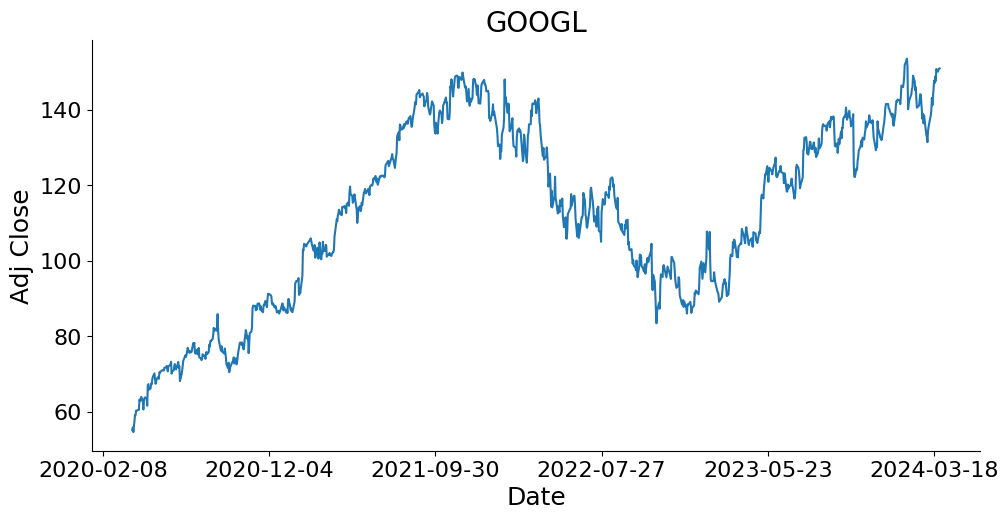

In [4]:
sns.relplot(market_data, x="Date", y="Adj Close", kind="line", aspect=2)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))
plt.title(ticker)
plt.savefig(f'/Users/rohitvernekar/My Drive/Rutgers/Financial Time Series Analysis/Project/Presentation/{ticker}-1.png', bbox_inches="tight")


### To use [SPCI](https://arxiv.org/abs/2212.03463), which performs better (i.e., intervals are narrower) but slower

In general, just pass in `X_full, Y_full` which are torch.tensor and specify what are the training samples and test samples by changing `train_frac`. Also, adjust `past_window` to specify the amount of past residuals to use when constructing intervals. 

For SPCI, larger `past_window` may or may not be better, depending on if there are "shifts" in the data distribution.

In [5]:
# Plot prediction intervals on test sample
def plot_ci(model, x_train, y_train, x_test, y_test, past_window = 30, alpha=0.1, save_path = None, title=None):

    SPCI_class_  = SPCI.SPCI_and_EnbPI(
        torch.from_numpy(x_train), 
        torch.from_numpy(x_test), 
        torch.from_numpy(y_train.reshape(-1)), 
        torch.from_numpy(y_test.reshape(-1)), 
        fit_func=model)
    stride = 1
    SPCI_class_.fit_bootstrap_models_online_multistep(B = 25, fit_sigmaX=False, stride=stride)

    use_SPCI = True
    smallT = not use_SPCI
    SPCI_class_.compute_PIs_Ensemble_online(alpha, smallT=smallT, past_window=past_window, use_SPCI=use_SPCI, quantile_regr=True, stride=stride)
    Pred_ints = SPCI_class_.PIs_Ensemble

    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label=r'$Y$')
    plt.plot(model.predict(x_test), label=r'$\hat{Y}$')
    plt.fill_between(np.arange(len(y_test)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$', color='lightblue')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3)
    plt.ylabel('Adj Close')
    if title:
        plt.title(ticker + title)
    else:
        plt.title(ticker)
    if save_path:
        plt.savefig(f'/Users/rohitvernekar/My Drive/Rutgers/Financial Time Series Analysis/Project/Presentation/{save_path}.png', bbox_inches="tight")

In [6]:
market_data.head()

,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal
Date,,,,,,,,
2020-04-01,56.200001,56.471001,54.674500,55.105000,55.105000,51970000,NaN,737516
2020-04-02,55.000000,56.138500,54.656502,55.851501,55.851501,56410000,0.013547,737517
2020-04-03,55.735500,55.939499,53.754002,54.634998,54.634998,51374000,-0.021781,737518
2020-04-06,56.650002,59.537498,56.250000,59.159500,59.159500,63320000,0.082813,737521
2020-04-07,60.850498,61.039001,58.862499,59.127998,59.127998,61620000,-0.000532,737522


In [7]:
market_data['5_day_avg'] = market_data['Adj Close'].rolling(window=5).mean().shift(1)
market_data['30_day_avg']= market_data['Adj Close'].rolling(window=30).mean().shift(1)
market_data['year_avg'] = market_data['Adj Close'].rolling(window=365).mean().shift(1)
market_data['avg_ratio'] = market_data['5_day_avg']/market_data['year_avg']

market_data['5_day_std'] = market_data['Adj Close'].rolling(window=5).std().shift(1)
market_data['year_std'] = market_data['Adj Close'].rolling(window=365).mean().shift(1)
market_data['std_ratio'] = market_data['5_day_std']/market_data['year_std']
market_data.head()

,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal,5_day_avg,30_day_avg,year_avg,avg_ratio,5_day_std,year_std,std_ratio
Date,,,,,,,,,,,,,,,
2020-04-01,56.200001,56.471001,54.674500,55.105000,55.105000,51970000,NaN,737516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-02,55.000000,56.138500,54.656502,55.851501,55.851501,56410000,0.013547,737517,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-03,55.735500,55.939499,53.754002,54.634998,54.634998,51374000,-0.021781,737518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-06,56.650002,59.537498,56.250000,59.159500,59.159500,63320000,0.082813,737521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-07,60.850498,61.039001,58.862499,59.127998,59.127998,61620000,-0.000532,737522,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
market_data = market_data.dropna()
print(market_data.shape)
x_train, x_test, y_train, y_test = train_test_split(market_data[['5_day_avg', '30_day_avg', 'year_avg', 'avg_ratio', '5_day_std','year_std', 'std_ratio']], market_data["Adj Close"], test_size=30/market_data.shape[0], shuffle=False)
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(640, 15)


((610, 7), (30, 7), (610, 1), (30, 1))

In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression()

1/1 multi-step: finish Fitting 25 Bootstrap models, took 0.04717707633972168 secs.
Shape of slided residual lists is (30, 610)
Width at test 0 is 8.082987785339355
Width at test 1 is 8.816140413284302
Width at test 2 is 9.256846010684967
Width at test 3 is 8.892395734786987
Width at test 4 is 8.423465967178345
Width at test 5 is 8.425646781921387
Width at test 6 is 8.5207679271698
Width at test 7 is 8.85405832529068
Width at test 8 is 8.275822639465332
Width at test 9 is 8.921698808670044
Width at test 10 is 7.841109991073608
Width at test 11 is 8.395150661468506
Width at test 12 is 8.867797672748566
Width at test 13 is 9.340118169784546
Width at test 14 is 8.693930268287659
Width at test 15 is 8.176130056381226
Width at test 16 is 8.205703973770142
Width at test 17 is 8.332253277301788
Width at test 18 is 6.875211477279663
Width at test 19 is 7.2647398710250854
Width at test 20 is 7.232689619064331
Width at test 21 is 8.94961953163147
Width at test 22 is 8.569416403770447
Width at tes

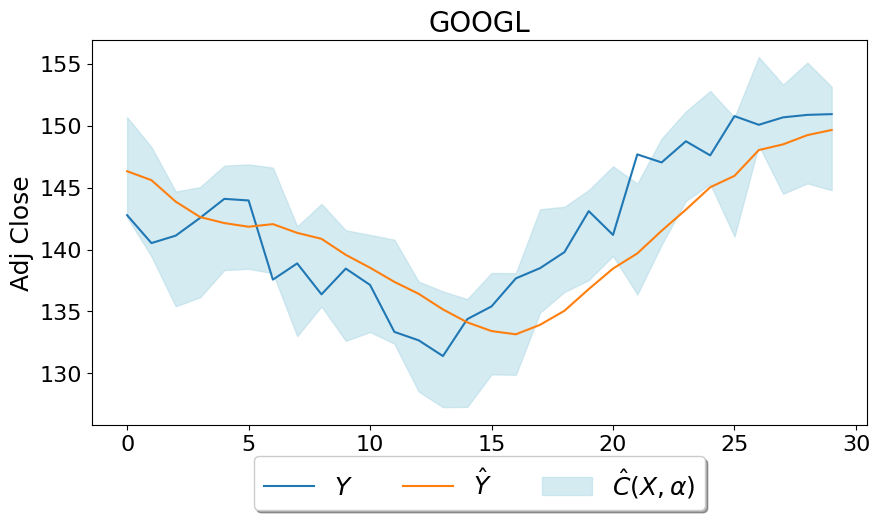

In [10]:
plot_ci(model, x_train, y_train, x_test, y_test, past_window=100, alpha=0.1, save_path=f"{ticker}-2")

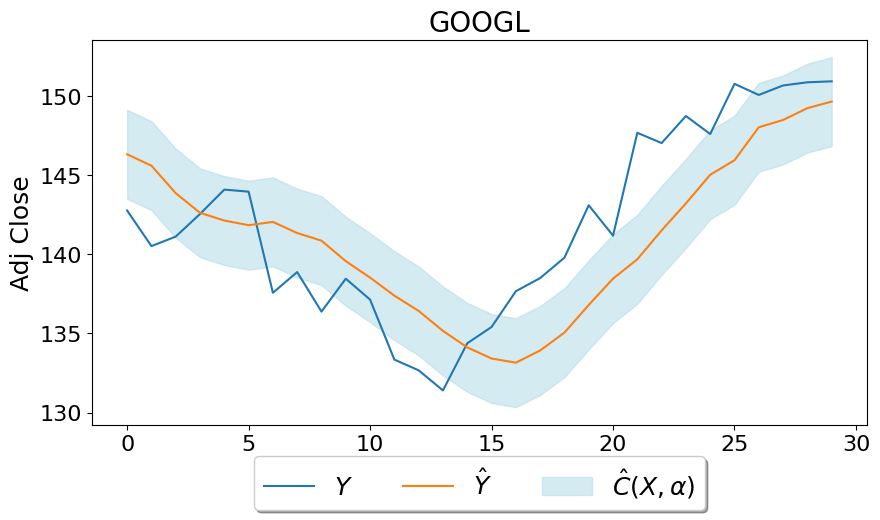

In [12]:
from scipy.stats import t

predictions = model.predict(x_test).reshape(-1)
test_length = 30

alpha = 0.1

residuals = y_test - predictions
mse = np.mean(residuals**2)
se = np.sqrt(mse / (test_length - 8))

t_statistic = t.ppf(1 - alpha / 2, test_length - 8)

lower_bound = predictions - t_statistic * se
upper_bound = predictions + t_statistic * se

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test, label=r'$Y$')
plt.plot(predictions, label=r'$\hat{Y}$')
plt.fill_between(np.arange(len(y_test)), lower_bound, upper_bound, alpha=0.5, label=r'$\hat{C}(X,\alpha)$', color='lightblue')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3)
plt.ylabel('Adj Close')
plt.title(ticker)
plt.savefig(f'/Users/rohitvernekar/My Drive/Rutgers/Financial Time Series Analysis/Project/Presentation/{ticker}-3.png', bbox_inches="tight")

In [13]:
import pandas as pd
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA

auto_arima(market_data["Adj Close"], seasonal=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2977.442, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2975.045, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2977.013, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2977.013, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2973.063, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2974.222, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.926 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [14]:
class Arima:
    def __init__(self):
        self.model = None
    
    def fit(self, x, y):
        self.model = ARIMA(order=(0,1,0)).fit(y)

    def predict(self, x):
        return self.model.predict(n_periods=len(x))

In [15]:
model = Arima()
model.fit(x_train, y_train)


In [16]:
model.predict(x_test)

array([145.94592608, 145.95184973, 145.95777337, 145.96369701,
       145.96962065, 145.9755443 , 145.98146794, 145.98739158,
       145.99331522, 145.99923886, 146.00516251, 146.01108615,
       146.01700979, 146.02293343, 146.02885708, 146.03478072,
       146.04070436, 146.046628  , 146.05255165, 146.05847529,
       146.06439893, 146.07032257, 146.07624621, 146.08216986,
       146.0880935 , 146.09401714, 146.09994078, 146.10586443,
       146.11178807, 146.11771171])

1/1 multi-step: finish Fitting 25 Bootstrap models, took 0.7938499450683594 secs.
Shape of slided residual lists is (30, 610)
Width at test 0 is 41.162095069885254
Width at test 1 is 42.030948638916016
Width at test 2 is 37.452805519104004
Width at test 3 is 39.009727478027344
Width at test 4 is 39.284626960754395
Width at test 5 is 38.89528274536133
Width at test 6 is 39.028151512145996
Width at test 7 is 38.22533416748047
Width at test 8 is 38.68980693817139
Width at test 9 is 40.126731872558594
Width at test 10 is 38.77984046936035
Width at test 11 is 38.61457920074463
Width at test 12 is 40.46337890625
Width at test 13 is 38.68881607055664
Width at test 14 is 37.99629306793213
Width at test 15 is 37.472920417785645
Width at test 16 is 38.66688823699951
Width at test 17 is 39.058531761169434
Width at test 18 is 38.95844745635986
Width at test 19 is 37.29191780090332
Width at test 20 is 43.01877498626709
Width at test 21 is 38.16810894012451
Width at test 22 is 40.54866981506348
Widt

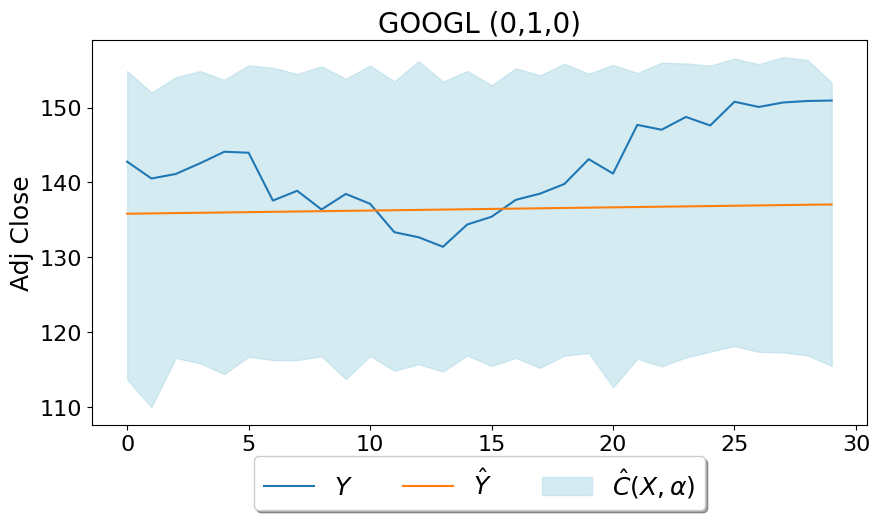

In [17]:
plot_ci(model, x_train, y_train, x_test, y_test, past_window=100, alpha=0.1, save_path=f"{ticker}-5", title=" (0,1,0)")

In [21]:
import tensorflow as tf

nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(50, input_shape=(x_train.shape[1],), activation=tf.nn.relu))
nn_model.add(tf.keras.layers.Dense(50, activation=tf.nn.relu))
nn_model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))

nn_model.compile(optimizer="adam", loss="mean_squared_error")

validation_samples = int(0.2 * x_train.shape[0])

nn_model.fit(x_train[:-validation_samples], y_train[:-validation_samples], 
          validation_data=(x_train[-validation_samples:], y_train[-validation_samples:]), 
          epochs=100)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4510.4189 - val_loss: 21.5687
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 282.3100 - val_loss: 15.5605
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 72.2374 - val_loss: 147.3622
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56.3867 - val_loss: 20.7815
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.7755 - val_loss: 49.5725
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.5160 - val_loss: 29.2352
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.2318 - val_loss: 31.2812
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.1146 - val_loss: 21.2981
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.1560 - val_loss: 24.7701
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.6833 - val_loss: 17.8500
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.4862 - val_loss: 17.8366
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.9483 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 17.3266
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 15.0686
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.2446 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.5779 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3202
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3236 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 17.2380
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 15.6745
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 14.1459
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0

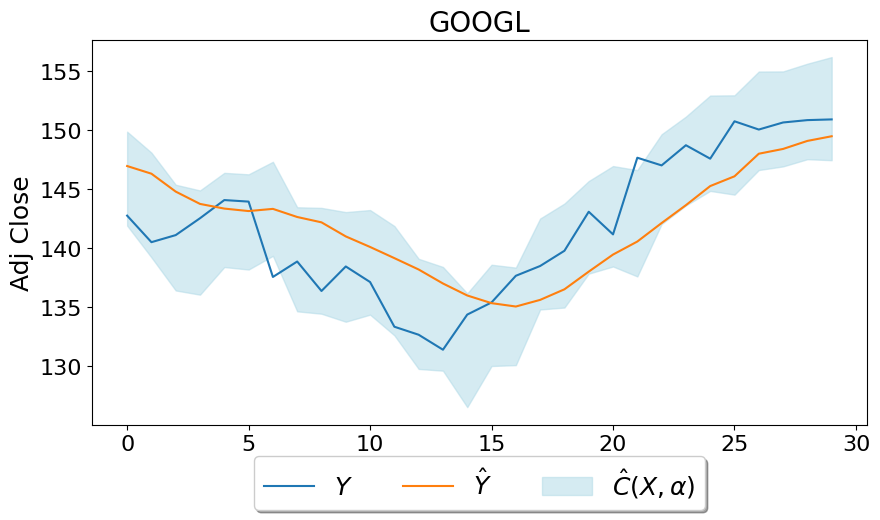

In [22]:
plot_ci(nn_model, x_train, y_train, x_test, y_test, past_window=100, alpha=0.1, save_path=f"{ticker}-4")

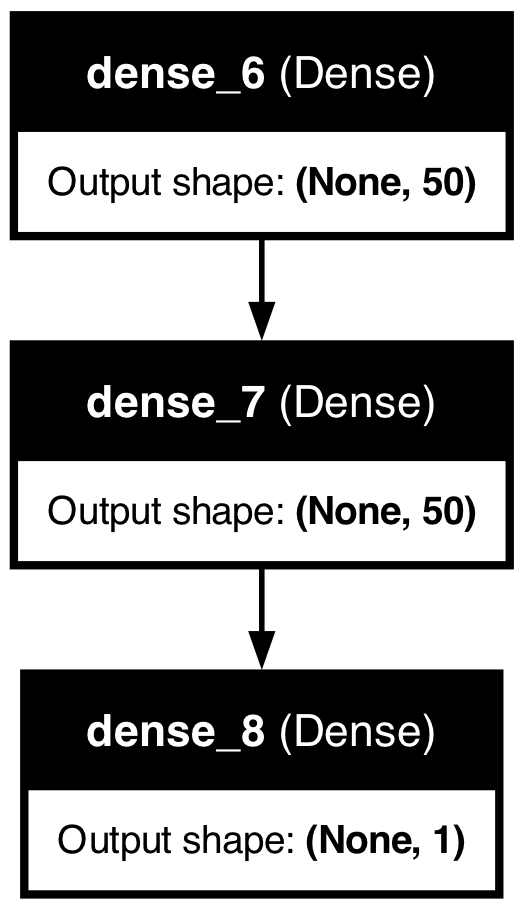

In [23]:
from keras.utils import plot_model
plot_model(nn_model, to_file=f'/Users/rohitvernekar/My Drive/Rutgers/Financial Time Series Analysis/Project/Presentation/nn.png', show_shapes=True, show_layer_names=True, expand_nested=True)
